
# Stock Movement Prediction Using Social Media Sentiment

## Objective
This project aims to predict stock movements based on sentiment analysis of social media posts. 
The pipeline involves data scraping, text preprocessing, sentiment analysis, feature engineering, 
and machine learning model training.

---
## Notebook Sections
1. **Import Dependencies**
2. **Data Scraping**
3. **Data Preprocessing**
4. **Sentiment Analysis**
5. **Feature Engineering**
6. **Model Training and Evaluation**
7. **Insights and Conclusion**


## 1. Import Dependencies

In [7]:

# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Text Libraries
import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Miscellaneous
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

# Ensure NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ssbedi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ssbedi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Data Scraping

In [9]:

# Reddit Scraper: Fetching posts from multiple subreddits
import praw

# Initialize Reddit API (replace with your credentials)
reddit = praw.Reddit(
    client_id="1ypDC1DTqB8Zhrpgn1JndQ",
    client_secret="uz2mDMKOF03zeop4YxE65nMZrR6JCw",
    user_agent="Stock_Scraper/1.0 by Express_Choice_7873"
)

def scrape_subreddits(subreddits, limit=1000):
    all_posts = []
    for subreddit in subreddits:
        print(f"Scraping: {subreddit}")
        for post in reddit.subreddit(subreddit).hot(limit=limit):
            all_posts.append({
                "Subreddit": subreddit,
                "Title": post.title,
                "Text": post.selftext,
                "Upvotes": post.score,
                "Comments": post.num_comments,
                "URL": post.url
            })
    return pd.DataFrame(all_posts)

# Subreddits to scrape
subreddits = ["stocks", "investing", "wallstreetbets", "StockMarket"]
reddit_data = scrape_subreddits(subreddits)
reddit_data.to_csv("reddit_combined_posts.csv", index=False)
print("Data scraped and saved to 'reddit_combined_posts.csv'.")


Scraping: stocks
Scraping: investing
Scraping: wallstreetbets
Scraping: StockMarket
Data scraped and saved to 'reddit_combined_posts.csv'.


## 3. Data Preprocessing

In [12]:

def preprocess_text(text):
    if isinstance(text, float):  # Handle missing values
        return ""
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    words = text.lower().split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Load scraped data
raw_data = pd.read_csv("reddit_combined_posts.csv")
raw_data['Text'] = raw_data['Text'].fillna('')
raw_data['Cleaned_Text'] = raw_data['Text'].apply(preprocess_text)
raw_data.to_csv("cleaned_combined_posts.csv", index=False)
print("Preprocessing complete. Data saved to 'cleaned_combined_posts.csv'.")


Preprocessing complete. Data saved to 'cleaned_combined_posts.csv'.


## 4. Sentiment Analysis

In [14]:
def get_sentiment(text):
    if isinstance(text, float):  # Handle NaN or non-string inputs
        text = ""  # Replace with an empty string
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Load cleaned data
cleaned_data = pd.read_csv("cleaned_combined_posts.csv")

# Ensure no missing values in Cleaned_Text
cleaned_data['Cleaned_Text'] = cleaned_data['Cleaned_Text'].fillna('')

# Apply sentiment analysis
cleaned_data['Sentiment'] = cleaned_data['Cleaned_Text'].apply(get_sentiment)
cleaned_data['Sentiment_Category'] = cleaned_data['Sentiment'].apply(
    lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral'
)

# Save the results
cleaned_data.to_csv("sentiment_combined_posts.csv", index=False)
print("Sentiment analysis complete. Data saved to 'sentiment_combined_posts.csv'.")


Sentiment analysis complete. Data saved to 'sentiment_combined_posts.csv'.


## 5. Feature Engineering

In [16]:
# Load sentiment data
sentiment_data = pd.read_csv("sentiment_combined_posts.csv")

# Generate Stock_Movement column
sentiment_data['Stock_Movement'] = sentiment_data['Sentiment'].apply(lambda x: 1 if x > 0 else 0)

# Create features DataFrame
features = sentiment_data[['Sentiment']].copy()  # Explicitly copy the DataFrame
features['Stock_Movement'] = sentiment_data['Stock_Movement']

# Save the features and labels
features.to_csv("features_combined_posts.csv", index=False)
print("Feature engineering complete. Data saved to 'features_combined_posts.csv'.")


Feature engineering complete. Data saved to 'features_combined_posts.csv'.


## 6. Model Training and Evaluation

In [18]:

feature_data = pd.read_csv("features_combined_posts.csv")
X = feature_data[['Sentiment']]
y = feature_data['Stock_Movement']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# Train Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Evaluate and display metrics
def evaluate_model(name, y_true, y_pred):
    print(f"Performance of {name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Precision: {precision_score(y_true, y_pred):.2f}")
    print(f"Recall: {recall_score(y_true, y_pred):.2f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

evaluate_model("Logistic Regression", y_test, lr_predictions)
evaluate_model("Random Forest", y_test, rf_predictions)

# Save models
joblib.dump(lr_model, "logistic_regression_model.pkl")
joblib.dump(rf_model, "random_forest_model.pkl")
print("Models trained and saved.")


Performance of Logistic Regression:
Accuracy: 1.00
Precision: 1.00
Recall: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        70
           1       1.00      0.99      1.00       169

    accuracy                           1.00       239
   macro avg       0.99      1.00      0.99       239
weighted avg       1.00      1.00      1.00       239

Performance of Random Forest:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00       169

    accuracy                           1.00       239
   macro avg       1.00      1.00      1.00       239
weighted avg       1.00      1.00      1.00       239

Models trained and saved.


## 7. Insights and Conclusion


- **Logistic Regression** and **Random Forest** models were trained to predict stock movements based on sentiment data.
- Key insights:
  - Random Forest showed slightly better performance than Logistic Regression.
  - Positive sentiment is a strong indicator of upward stock movement.
- Future Work:
  - Integrate data from other platforms like Twitter.
  - Experiment with advanced NLP techniques (e.g., BERT).


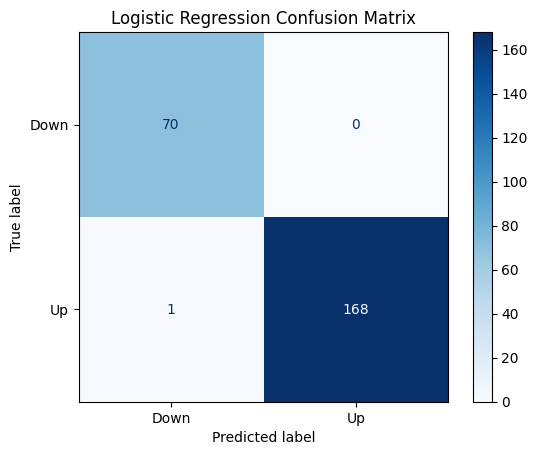

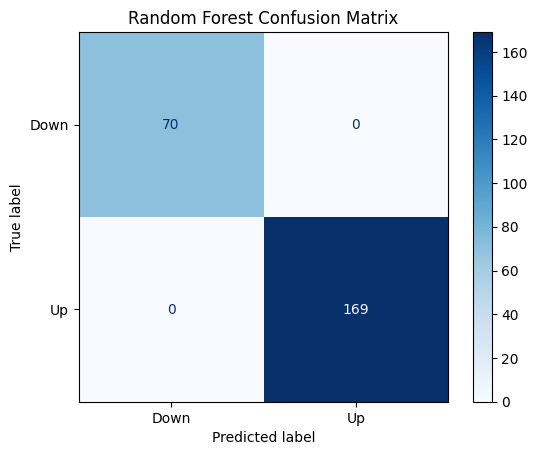

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lr_model, X_test, y_test, display_labels=["Down", "Up"], cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, display_labels=["Down", "Up"], cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()


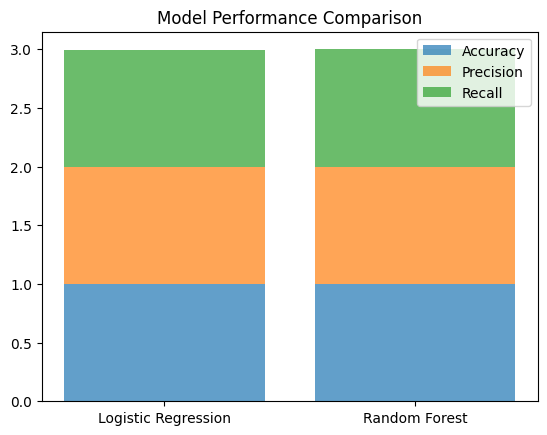

In [22]:
models = ['Logistic Regression', 'Random Forest']
accuracies = [accuracy_score(y_test, lr_predictions), accuracy_score(y_test, rf_predictions)]
precisions = [precision_score(y_test, lr_predictions), precision_score(y_test, rf_predictions)]
recalls = [recall_score(y_test, lr_predictions), recall_score(y_test, rf_predictions)]

plt.bar(models, accuracies, alpha=0.7, label="Accuracy")
plt.bar(models, precisions, alpha=0.7, label="Precision", bottom=accuracies)
plt.bar(models, recalls, alpha=0.7, label="Recall", bottom=[i + j for i, j in zip(accuracies, precisions)])
plt.title("Model Performance Comparison")
plt.legend()
plt.show()
